<h1>Classification Model<h1>

In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder, MinMaxScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score,precision_score,recall_score,f1_score,ConfusionMatrixDisplay
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
from imblearn.over_sampling import SMOTE
import joblib

In [14]:
df = pd.read_csv("student_recommendation_dataset.csv")
new_features_df = pd.read_csv("new_features_rwanda_students.csv", dtype=str)

df = pd.concat([df, new_features_df], axis=1)
df.to_csv('rwanda_students_dataset.csv')

# Display first few rows
df.head()


student_id  age  gender school_type location  math_score  english_score  \
0      S0001   18  Female      Public    Rural          89             78   
1      S0002   19  Female     Private    Rural          84             60   
2      S0003   17  Female      Public    Rural          41             49   
3      S0004   19    Male      Public    Rural          80             77   
4      S0005   19  Female      Public    Urban          60             85   

   science_score  history_score  attendance_rate  ...  job_demand_business  \
0             99             73         0.959424  ...             0.607863   
1             52             50         0.913279  ...             0.403364   
2             54             75         0.912150  ...             0.676472   
3             57             90         0.783198  ...             0.189933   
4             90             56         0.759202  ...             0.818747   

   job_demand_healthcare  job_demand_arts  job_demand_humanities  \
0               0.283746         0.630851               0.433464   
1               0.436582         0.349585               0.396728   
2               0.633797         0.292671               0.938054   
3               0.450052         0.392588               0.153135   
4               0.337817         0.342023               0.009847   

   parental_education_level  household_income  internet_access  \
0                  Tertiary              1083             True   
1                 Secondary               803             True   
2                 Secondary               575            False   
3                   Primary               691             True   
4                       NaN               115            False   

   recommended_stream  parental_career  extracurricular_activity  
0                STEM       Healthcare                       NaN  
1          Healthcare             Arts     Entrepreneurship Club  
2          Humanities         Business     Entrepreneurship Club  
3          Healthcare             Arts                     Music  
4            Business             Arts              Science Club  

[5 rows x 27 columns]

- Exploratory Data Analysis

In [15]:
print(df.isnull().sum()) #check for missing values

student_id                   0
age                          0
gender                       0
school_type                  0
location                     0
math_score                   0
english_score                0
science_score                0
history_score                0
attendance_rate              0
study_hours_per_week         0
interest_stem                0
interest_humanities          0
interest_arts                0
interest_business            0
interest_healthcare          0
job_demand_stem              0
job_demand_business          0
job_demand_healthcare        0
job_demand_arts              0
job_demand_humanities        0
parental_education_level    47
household_income             0
internet_access              0
recommended_stream           0
parental_career             90
extracurricular_activity    91
dtype: int64


In [16]:
df.info() #dataset information

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 27 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   student_id                500 non-null    object 
 1   age                       500 non-null    int64  
 2   gender                    500 non-null    object 
 3   school_type               500 non-null    object 
 4   location                  500 non-null    object 
 5   math_score                500 non-null    int64  
 6   english_score             500 non-null    int64  
 7   science_score             500 non-null    int64  
 8   history_score             500 non-null    int64  
 9   attendance_rate           500 non-null    float64
 10  study_hours_per_week      500 non-null    int64  
 11  interest_stem             500 non-null    float64
 12  interest_humanities       500 non-null    float64
 13  interest_arts             500 non-null    float64
 14  interest_b

In [17]:
df.duplicated().sum() #check for ant data duplicates

0

- Data preprocessing

- Visualizations

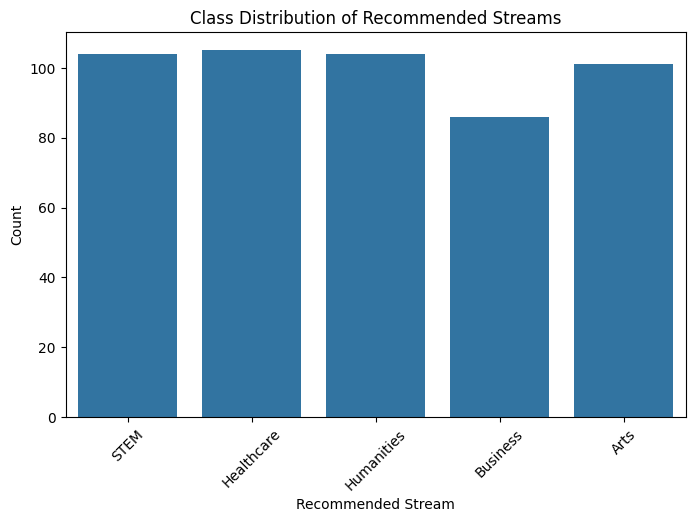

In [18]:
# 6. Visualize class distribution
plt.figure(figsize=(8,5))
sns.countplot(x=df["recommended_stream"])
plt.title("Class Distribution of Recommended Streams")
plt.xlabel("Recommended Stream")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.show()

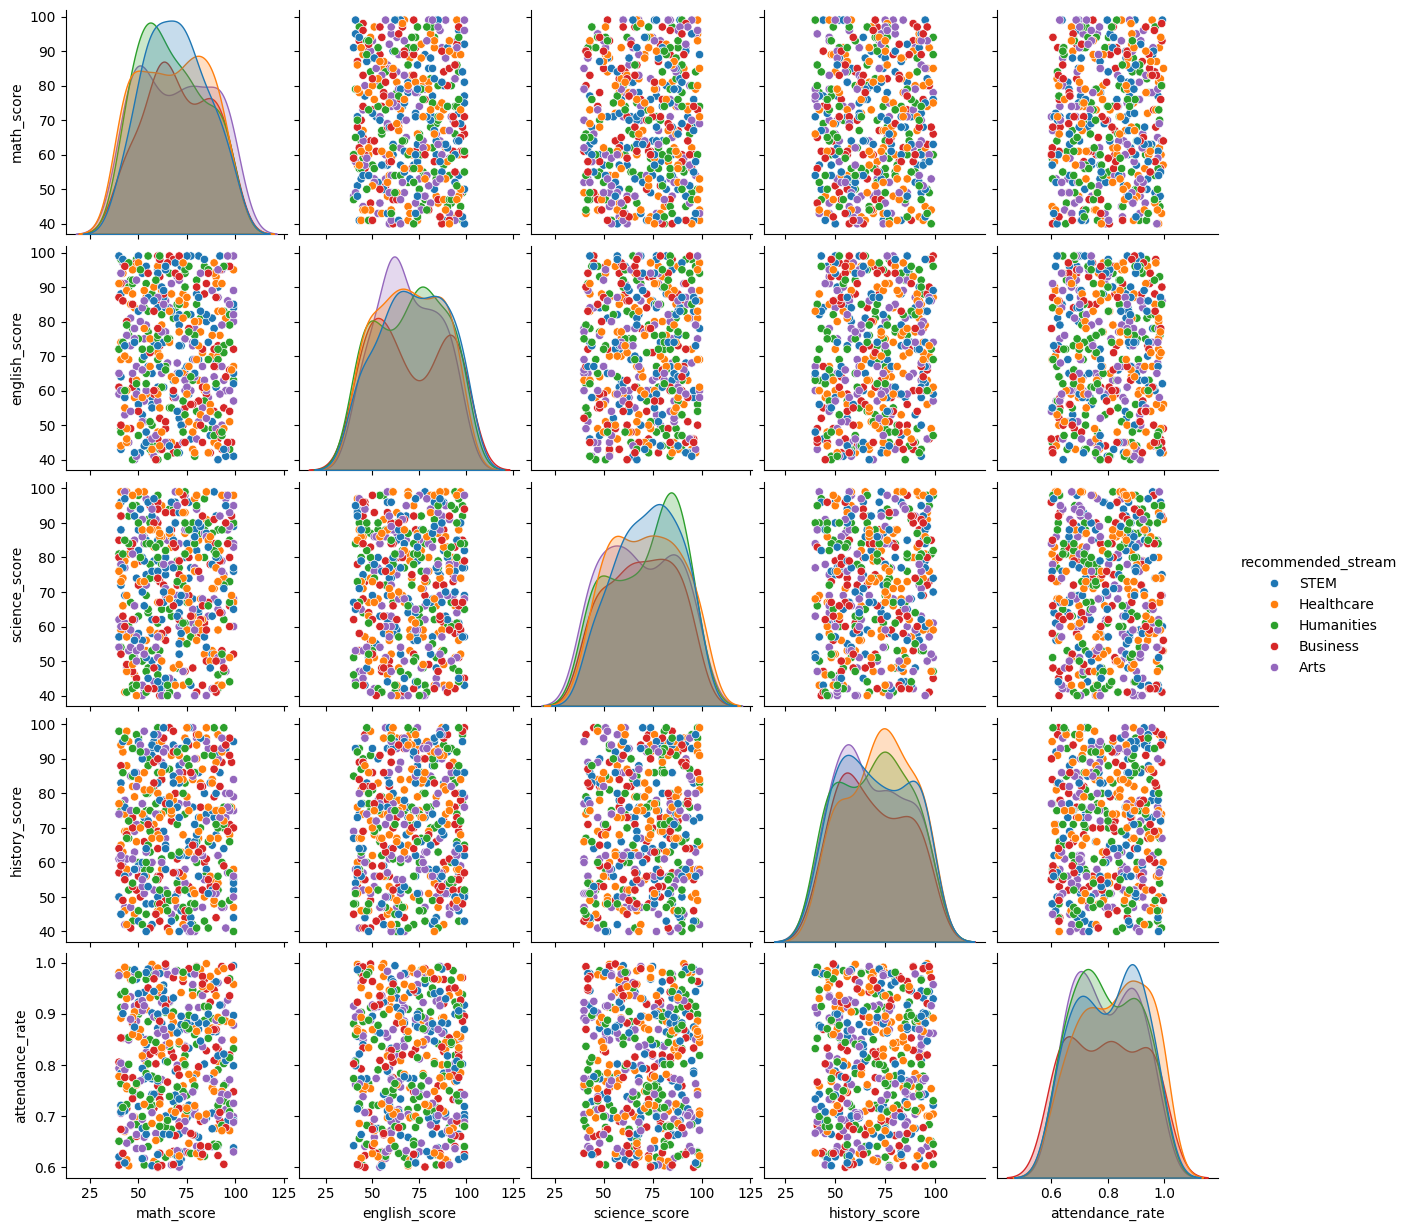

In [19]:
#selecting a subset of important numerical features for visualization
selected_features = ["math_score", "english_score", "science_score", "history_score", "attendance_rate"]

sns.pairplot(df[selected_features + ["recommended_stream"]], hue="recommended_stream", palette="tab10")
plt.show()

C:\Users\Hp\AppData\Local\Temp\ipykernel_15108\2990839258.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=df["recommended_stream"], y=df["math_score"], palette="coolwarm")


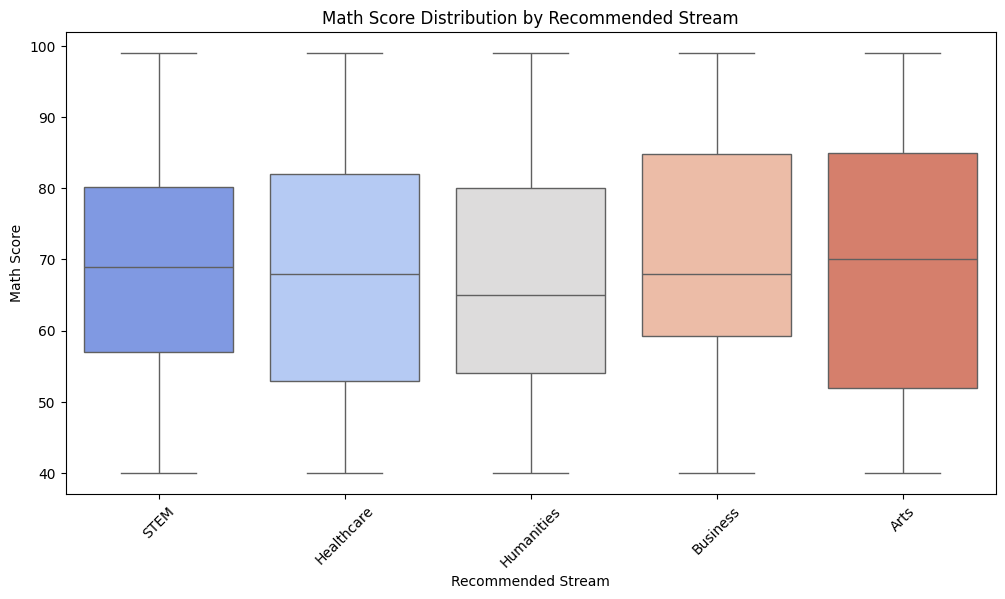

In [20]:
plt.figure(figsize=(12,6))

# Plot scores for each recommended stream
sns.boxplot(x=df["recommended_stream"], y=df["math_score"], palette="coolwarm")
plt.title("Math Score Distribution by Recommended Stream")
plt.xlabel("Recommended Stream")
plt.ylabel("Math Score")
plt.xticks(rotation=45)
plt.show()

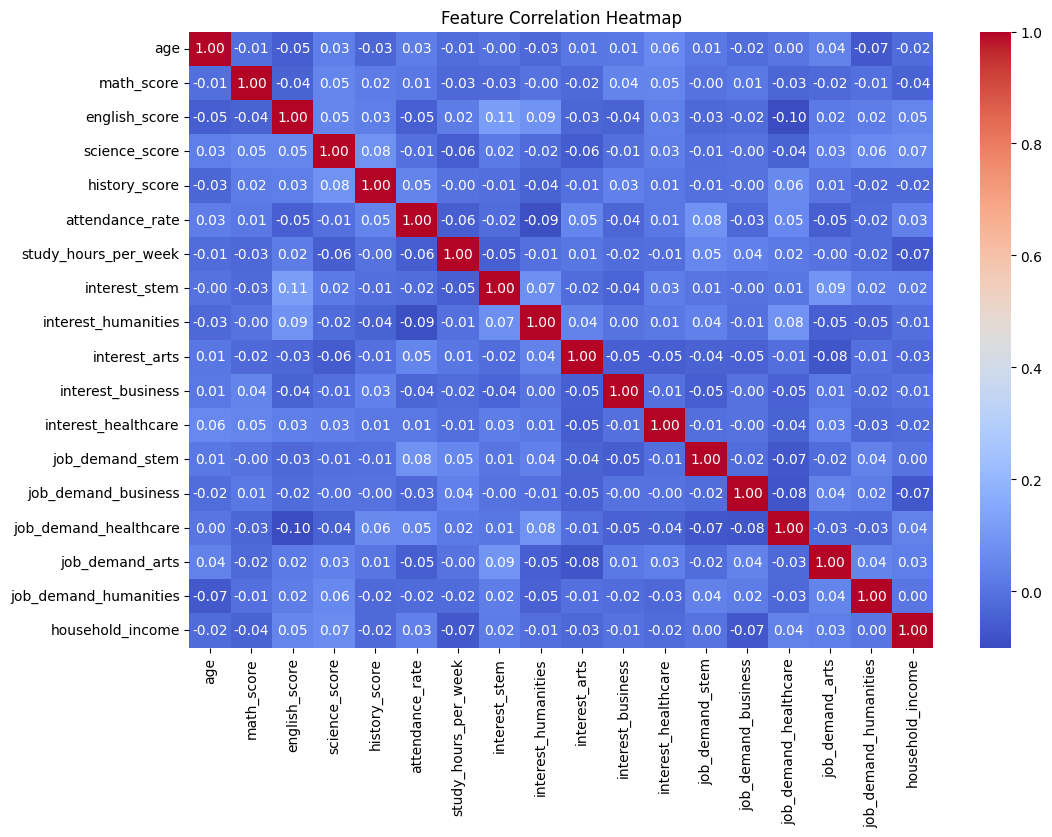

In [21]:
# 7. Correlation Heatmap (Numerical Features)
plt.figure(figsize=(12,8))

# Select only numeric columns
numeric_df = df.select_dtypes(include=[np.number])  # Excludes student_id and categorical strings

sns.heatmap(numeric_df.corr(), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Feature Correlation Heatmap")
plt.show()


- Data Preprocessing

In [22]:
df["parental_career"].fillna("None", inplace=True)
df["extracurricular_activity"].fillna("None", inplace=True) #replace NaN with None

C:\Users\Hp\AppData\Local\Temp\ipykernel_15108\2255694510.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["parental_career"].fillna("None", inplace=True)
C:\Users\Hp\AppData\Local\Temp\ipykernel_15108\2255694510.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example

Using
 One-Hot Encoding to treat categorical columns

In [23]:
df = pd.get_dummies(df, columns=["gender", "school_type", "location", "parental_education_level", 
                                 "internet_access", "parental_career", "extracurricular_activity"], drop_first=True)
df.head()

student_id  age  math_score  english_score  science_score  history_score  \
0      S0001   18          89             78             99             73   
1      S0002   19          84             60             52             50   
2      S0003   17          41             49             54             75   
3      S0004   19          80             77             57             90   
4      S0005   19          60             85             90             56   

   attendance_rate  study_hours_per_week  interest_stem  interest_humanities  \
0         0.959424                    22       0.715186             0.780919   
1         0.913279                    26       0.281919             0.791464   
2         0.912150                    26       0.363810             0.602470   
3         0.783198                     5       0.190726             0.511639   
4         0.759202                    21       0.347062             0.061007   

   ...  parental_career_Business  parental_career_Healthcare  \
0  ...                     False                        True   
1  ...                     False                       False   
2  ...                      True                       False   
3  ...                     False                       False   
4  ...                     False                       False   

   parental_career_Humanities  parental_career_None  parental_career_STEM  \
0                       False                 False                 False   
1                       False                 False                 False   
2                       False                 False                 False   
3                       False                 False                 False   
4                       False                 False                 False   

   extracurricular_activity_Entrepreneurship Club  \
0                                           False   
1                                            True   
2                                            True   
3                                           False   
4                                           False   

   extracurricular_activity_Music  extracurricular_activity_None  \
0                           False                           True   
1                           False                          False   
2                           False                          False   
3                            True                          False   
4                           False                          False   

   extracurricular_activity_Science Club extracurricular_activity_Sports  
0                                  False                           False  
1                                  False                           False  
2                                  False                           False  
3                                  False                           False  
4                                   True                           False  

[5 rows x 36 columns]

In [24]:
x = df.drop(columns=["recommended_stream", "student_id"])
y = df["recommended_stream"]

In [25]:
scaler = MinMaxScaler()
numerical_cols = ["math_score", "english_score", "science_score", "history_score", 
                  "attendance_rate", "study_hours_per_week", "household_income"]
x[numerical_cols] = scaler.fit_transform(x[numerical_cols]) #scale the data to be between 0 and 1


SMOTE for handling target class imbalance

In [26]:
smote = SMOTE(sampling_strategy="auto", random_state=42)
x_resampled, y_resampled = smote.fit_resample(x, y)

- Model Training

In [27]:
x_train, x_test, y_train, y_test = train_test_split(x_resampled, y_resampled, test_size=0.2, random_state=42, stratify=y_resampled)

print(f"Training set: {x_train.shape}, Testing set: {x_test.shape}")


Training set: (420, 34), Testing set: (105, 34)


In [28]:
rf_classifier = RandomForestClassifier(
    n_estimators=300,
    max_depth=15,
    min_samples_split=5,
    min_samples_leaf=2,
    max_features='sqrt',
    bootstrap=True,
    class_weight="balanced",  # Adjusts for class imbalance
    random_state=42
)
rf_classifier.fit(x_train, y_train)


RandomForestClassifier(class_weight='balanced', max_depth=15,
                       min_samples_leaf=2, min_samples_split=5,
                       n_estimators=300, random_state=42)

Feature importance will be used to create a final model for improved accuracy by keeping the features that contributes best to the RandomForest Classifer performance.

In [29]:
importances = rf_classifier.feature_importances_ #get feature importance
feature_names = x_train.columns
feature_importance_df = pd.DataFrame({"Feature": feature_names, "Importance": importances})
feature_importance_df.sort_values(by="Importance", ascending=False, inplace=True)

print(feature_importance_df) #top features

                                           Feature  Importance
10                               interest_business    0.078740
9                                    interest_arts    0.076508
16                           job_demand_humanities    0.075779
11                             interest_healthcare    0.072525
12                                 job_demand_stem    0.072287
14                           job_demand_healthcare    0.072158
15                                 job_demand_arts    0.068879
13                             job_demand_business    0.068445
7                                    interest_stem    0.068166
8                              interest_humanities    0.062863
5                                  attendance_rate    0.031827
1                                       math_score    0.029825
17                                household_income    0.029149
2                                    english_score    0.028660
3                                    science_score    0

In [30]:
important_features = feature_importance_df["Feature"].head(23).tolist() #keep top 23 features
X_train = x_train[important_features]
X_test = x_test[important_features]


Create a final RandomForest model

In [31]:
rf_classifier2 = RandomForestClassifier(
    n_estimators=400,  
    max_depth=25,      
    min_samples_split=5,
    min_samples_leaf=2,
    max_features='sqrt',
    bootstrap=True,
    class_weight="balanced",  # Adjusts for class imbalance
    random_state=42
)
rf_classifier2.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced', max_depth=25,
                       min_samples_leaf=2, min_samples_split=5,
                       n_estimators=400, random_state=42)

In [32]:
print("Training features:", rf_classifier2.feature_names_in_)

Training features: ['interest_business' 'interest_arts' 'job_demand_humanities'
 'interest_healthcare' 'job_demand_stem' 'job_demand_healthcare'
 'job_demand_arts' 'job_demand_business' 'interest_stem'
 'interest_humanities' 'attendance_rate' 'math_score' 'household_income'
 'english_score' 'science_score' 'history_score' 'study_hours_per_week'
 'age' 'parental_education_level_Secondary' 'internet_access_True'
 'school_type_Public' 'location_Urban' 'gender_Male']


- Model Evaluation

In [33]:
y_pred = rf_classifier2.predict(X_test)
y_test_bin = label_binarize(y_test, classes=np.unique(y_test)) #binarize the output labels for multiclass
y_pred_bin = label_binarize(y_pred, classes=np.unique(y_test))

#compute AUC score
roc_auc = roc_auc_score(y_test_bin, y_pred_bin, average="weighted", multi_class="ovr")

#evaluate performance
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred, average='weighted'))
print("Recall:", recall_score(y_test, y_pred, average='weighted'))
print("F1-Score:", f1_score(y_test, y_pred, average='weighted'))
print("Weighted ROC AUC Score:", roc_auc)

Accuracy: 0.8
Precision: 0.8113002291825822
Recall: 0.8
F1-Score: 0.8025194802834851
Weighted ROC AUC Score: 0.875


- Classification Report, Confusion Matrix, ROC AUC Curve

In [34]:
print("\nClassification Report:\n", classification_report(y_test, y_pred))


Classification Report:
               precision    recall  f1-score   support

        Arts       0.94      0.76      0.84        21
    Business       0.86      0.86      0.86        21
  Healthcare       0.82      0.86      0.84        21
  Humanities       0.64      0.76      0.70        21
        STEM       0.80      0.76      0.78        21

    accuracy                           0.80       105
   macro avg       0.81      0.80      0.80       105
weighted avg       0.81      0.80      0.80       105



<Figure size 800x600 with 0 Axes>

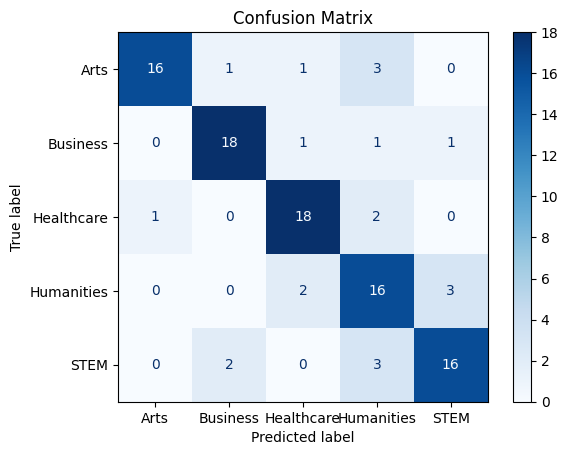

In [35]:
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8,6))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.unique(y_test))
disp.plot(cmap="Blues", values_format='d')
plt.title("Confusion Matrix")
plt.show()

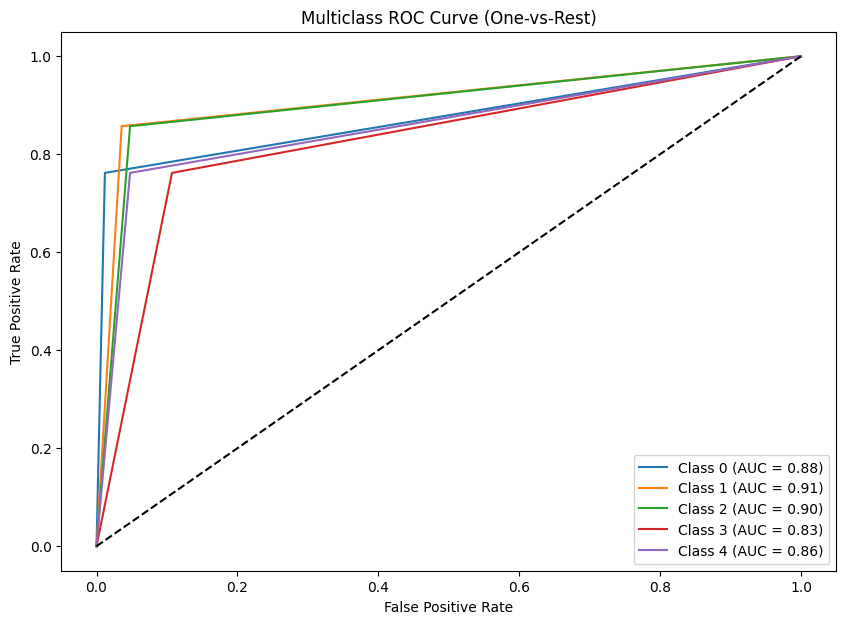

In [36]:
plt.figure(figsize=(10,7))
for i in range(y_test_bin.shape[1]):
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_pred_bin[:, i])
    plt.plot(fpr, tpr, label=f"Class {i} (AUC = {auc(fpr, tpr):.2f})")

plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Multiclass ROC Curve (One-vs-Rest)")
plt.legend()
plt.show()

In [37]:
rf_classifier2.predict([X_train.iloc[9]])

c:\Users\Hp\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


array(['Humanities'], dtype=object)

- Save the model

In [38]:
joblib.dump(rf_classifier2, "random_forest_model.pkl")

['random_forest_model.pkl']